Step 1: Load the data and prepare the input data for Meridian

In [58]:
# GitHub-friendly inline rendering for Altair + Matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Altair: render charts as PNG (embedded into notebook outputs)
import altair as alt
alt.data_transformers.disable_max_rows()
# Requires: pip install vl-convert-python
alt.renderers.enable('png')


RendererRegistry.enable('png')

In [43]:
# Step 1: Load the data and prepare the input data for Meridian
from meridian.data import data_frame_input_data_builder
import pandas as pd

# Use relative path (your notebook lives in marketing_mix_model/model/)
data_path = '../data/mmm_daily_agg.csv'
mm = pd.read_csv(data_path, parse_dates=['click_date']) \
       .rename(columns={
           'clicks_google': 'clicks_Google',
           'clicks_meta': 'clicks_Meta',
           'clicks_linkedin': 'clicks_LinkedIn',
           'spend_google': 'spend_Google',
           'spend_meta': 'spend_Meta',
           'spend_linkedin': 'spend_LinkedIn',
           'click_date': 'time'
       }) \
       .sort_values('time')

from meridian.data import data_frame_input_data_builder as dfib

df_builder = dfib.DataFrameInputDataBuilder(
    kpi_type='revenue',
    default_kpi_column='revenue_total'
)

builder = df_builder.with_kpi(mm, time_col='time')

control_columns = ['holiday_flag', 'promo_discount', 'competitor_index']
builder = builder.with_controls(mm, control_cols=control_columns, time_col='time')

channels = ['Google','Meta','LinkedIn']
media_columns       = [f'clicks_{ch}' for ch in channels]
media_spend_columns = [f'spend_{ch}'  for ch in channels]

builder = builder.with_media(
    mm,
    media_cols=media_columns,
    media_spend_cols=media_spend_columns,
    media_channels=channels
)

input_data = builder.build()
print("Input data ready.")

Input data ready.


In [44]:
# Step 2: Specify the model configuration
import tensorflow_probability as tfp
import tensorflow as tf
from meridian.model import prior_distribution, spec, model

tf.get_logger().setLevel('ERROR')
warnings.filterwarnings('ignore', category=UserWarning, module='tensorflow')

roi_mu, roi_sigma = 0.2, 0.9
priors = prior_distribution.PriorDistribution(
    roi_m=tfp.distributions.LogNormal(roi_mu, roi_sigma, name='roi_m')
)

model_spec = spec.ModelSpec(
    prior=priors,
    max_lag=14,
    hill_before_adstock=False,
    knots=10
)

mmm = model.Meridian(input_data=input_data, model_spec=model_spec)
print("Model initialized.")

Model initialized.


Step 3: Sample the model

In [45]:
# Step 3: Sample the model
mmm.sample_prior(300)

mmm.sample_posterior(
    n_chains=4,
    n_adapt=2000,
    n_burnin=1000,
    n_keep=1500,
    seed=0
)
print("Sampling done.")

W0000 00:00:1755159036.920389   43200 assert_op.cc:38] Ignoring Assert operator mcmc_retry_init/assert_equal_1/Assert/AssertGuard/Assert


Sampling done.


Step 4: Model diagnostics

4.1 Convergence diagnostics

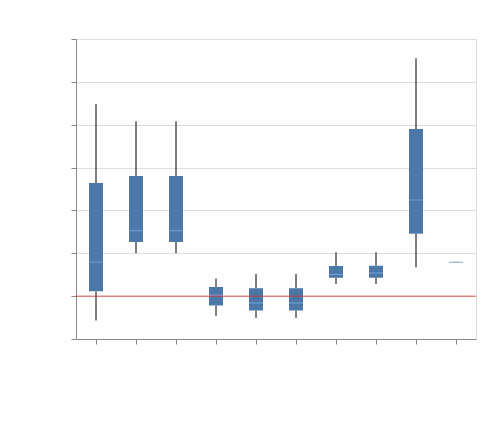

In [59]:
# 4.1 Convergence diagnostics
from meridian.analysis import visualizer

diagnostics = visualizer.ModelDiagnostics(mmm)
diagnostics.plot_rhat_boxplot()


We ran an r-hat diagnostic to check convergence of the model. The r-hat value should be close to 1.0 for all parameters, indicating that the chains have converged. A common rule of thumb is < 1.10 for acceptable results. Our results are all extremely close to 1.0 which is to be expected considering that we used perfect dummy-data to train the model. This is an indicator that the model has learned the underlying patterns in the data effectively and we can make decisions based on it.

4.2 Model Fit

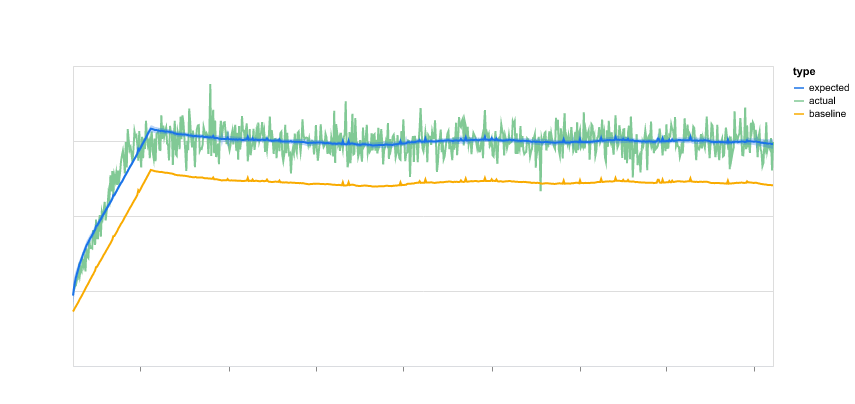

In [60]:
model_fit = visualizer.ModelFit(mmm)
model_fit.plot_model_fit()

The model replicates the overall trend in the data, capturing the peaks and troughs in revenue. The model fit is good, indicating that the model has learned the underlying patterns in the data effectively.

Step 5: Analyze the results

5.1 Channel Contribution Analysis

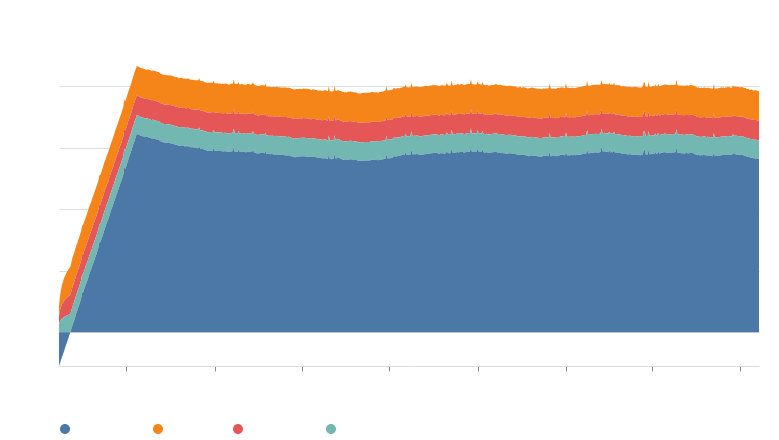

In [61]:
media_summary = visualizer.MediaSummary(mmm)

# Contribution of media channels
media_summary.plot_channel_contribution_area_chart()

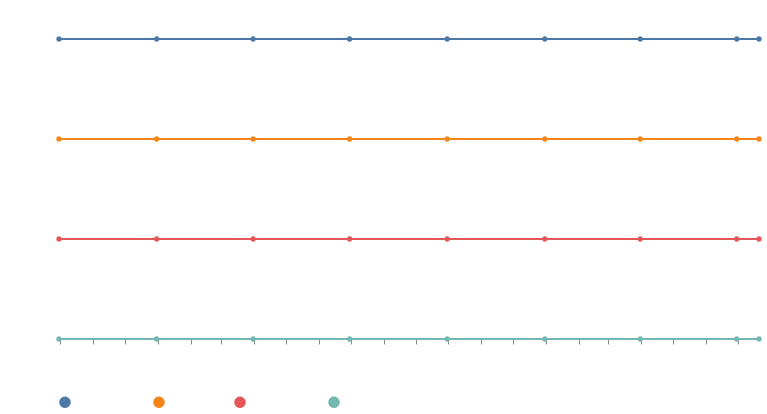

In [62]:
media_summary.plot_channel_contribution_bump_chart()

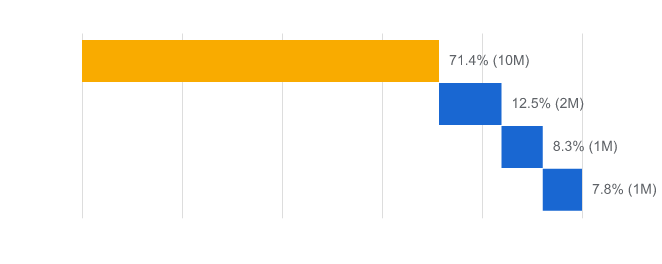

In [63]:
media_summary.plot_contribution_waterfall_chart()

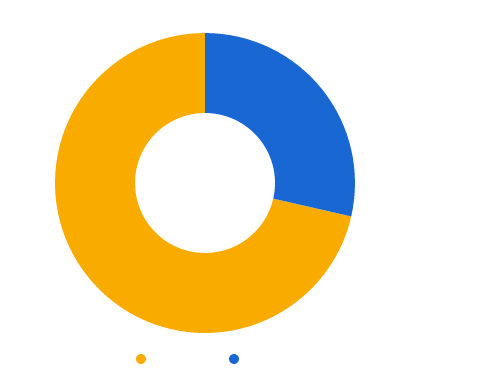

In [64]:
media_summary.plot_contribution_pie_chart()

5.2 Spend vs Contribution to ROI

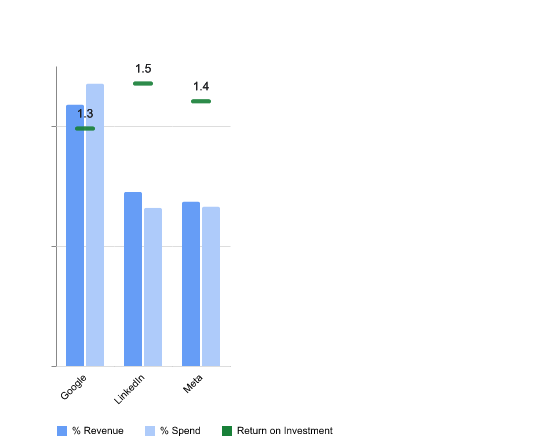

In [65]:
media_summary.plot_spend_vs_contribution()

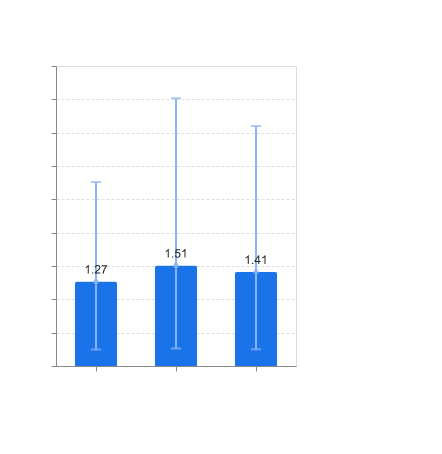

In [66]:
media_summary.plot_roi_bar_chart()

5.3 Response and Saturation Curves

These curves show the relationship between media spend and the response (revenue) generated by each channel. The response curve shows how much revenue is generated for each dollar spent on media, while the saturation curve shows how much additional revenue is generated as spend increases. The curves can help identify the optimal level of spend for each channel to maximize ROI.

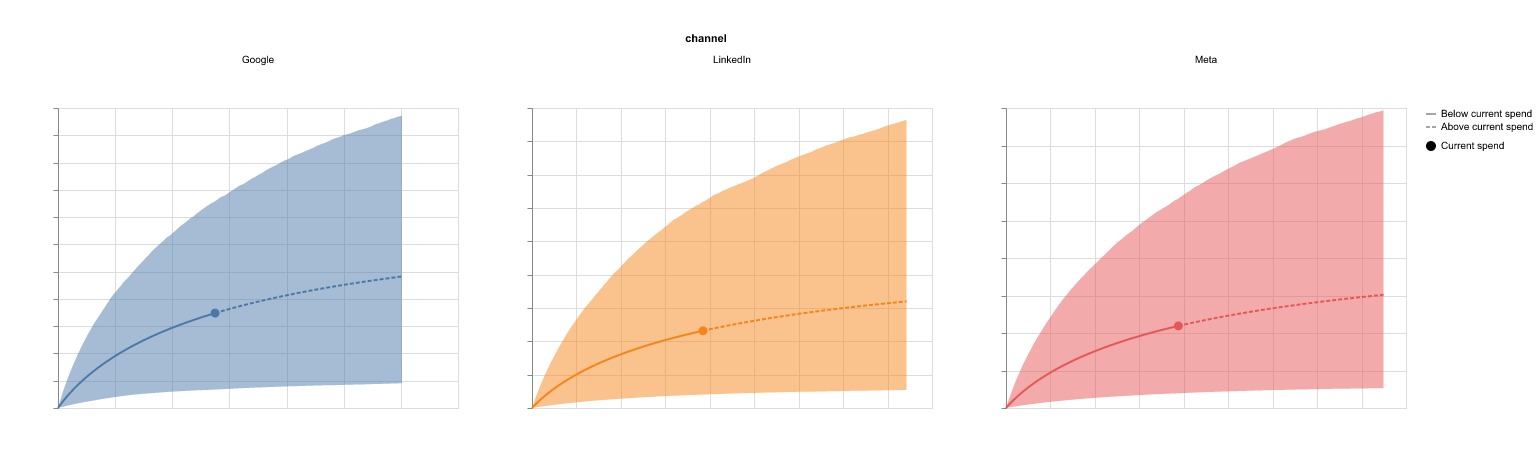

In [67]:
media_effects = visualizer.MediaEffects(mmm)

media_effects.plot_response_curves()

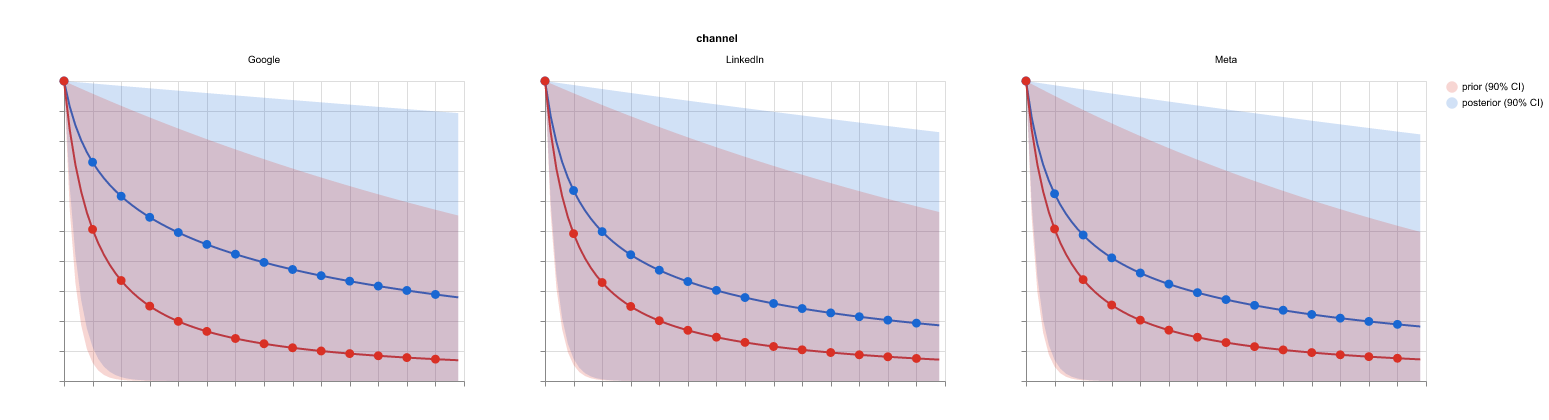

In [68]:
media_effects.plot_adstock_decay()

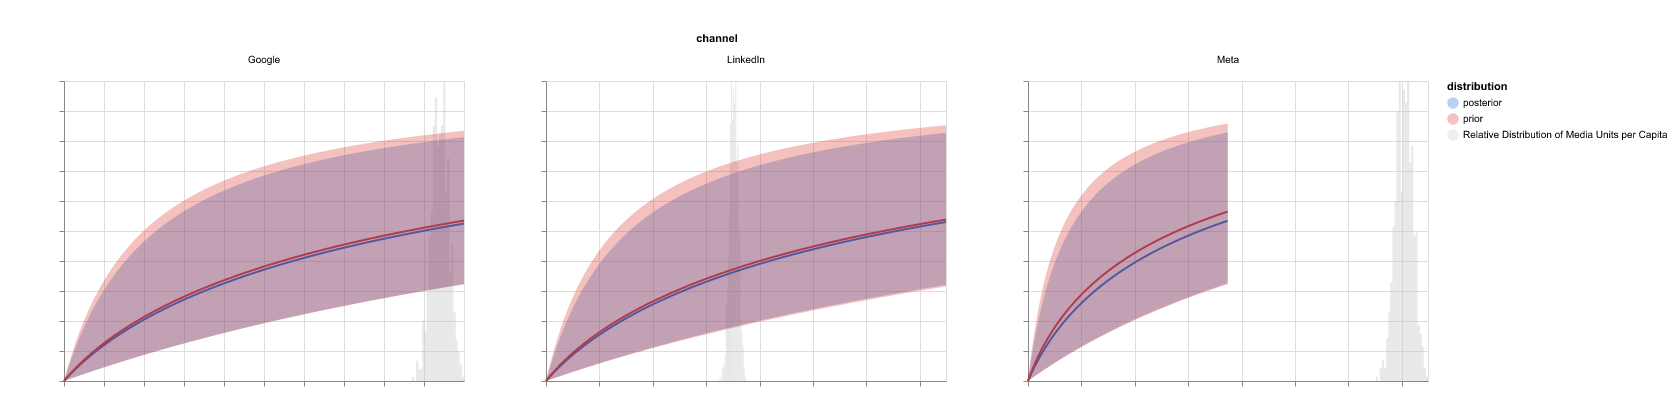

In [69]:
hill_chart = media_effects.plot_hill_curves()
hill_chart['media']

Step 6: Create a Summary Report

In [ ]:
'''from meridian.analysis import summarizer
import os

summary = summarizer.Summarizer(mmm)

# Create a local results directory
results_dir = './results'
os.makedirs(results_dir, exist_ok=True)

summary.output_model_results_summary(
    filename='mmm_summary.html',
    filepath=results_dir,  # Just the directory path, not the full file path
)'''

# This has been uploaded as a pdf to the results directory